Pytorch Implementation of Deep Q Network from https://www.youtube.com/watch?v=UlJzzLYgYoE&t=3s

# What I changed:

Now uses an actual target Q network, and does not update target network at every step, but every n steps. Polyak averaging also a possibility. 

After this I want to try a Double DQN.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import gym

%matplotlib inline

DQN has several sub-modules: Experience Buffer, the network, and the agent. Bringing all these together makes the DQN

In [4]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
    def __init__(self, ALPHA, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=ALPHA)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, observation):
        state = T.Tensor(observation).to(self.device)
        #observation = observation.view(-1)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        return actions

class Agent(object):
    #No target update? 
    def __init__(self, gamma, epsilon, alpha, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.01, eps_dec=0.996,target_update=100):
        self.GAMMA = gamma
        self.EPSILON = epsilon
        self.EPS_MIN = eps_end
        self.EPS_DEC = eps_dec
        self.ALPHA = alpha
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.Q_eval = DeepQNetwork(alpha, n_actions=self.n_actions,
                              input_dims=input_dims, fc1_dims=256, fc2_dims=256)
        self.Q_target = DeepQNetwork(alpha, n_actions=self.n_actions,
                              input_dims=input_dims, fc1_dims=256, fc2_dims=256)
        
    
        self.state_memory = np.zeros((self.mem_size, *input_dims))
        self.new_state_memory = np.zeros((self.mem_size, *input_dims))
        self.action_memory = np.zeros((self.mem_size, self.n_actions),
                                      dtype=np.uint8)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)
        self.target_counter = 0 #update target counter 
        self.target_update = target_update
        
    def storeTransition(self, state, action, reward, state_, terminal):
        
        #stores s a s' r and done flag for td updates. 
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        actions = np.zeros(self.n_actions)
        actions[action] = 1.0 #one hot encodes the action
        self.action_memory[index] = actions
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = 1 - terminal
        self.mem_cntr += 1 #update total size so we know when to update it. 

    def chooseAction(self, observation):
        #select an action according to epsilon greedy strategy. 
        rand = np.random.random()
        actions = self.Q_eval.forward(observation)
        if rand > self.EPSILON:
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action

    def learn(self):
        if self.mem_cntr > self.batch_size: 
            #once you have accumulated enough transitions, begin training. 
            self.Q_eval.optimizer.zero_grad()

            max_mem = self.mem_cntr if self.mem_cntr < self.mem_size \
                                    else self.mem_size

            
            batch = np.random.choice(max_mem, self.batch_size)
            
            state_batch = self.state_memory[batch]
            action_batch = self.action_memory[batch]
            action_values = np.array(self.action_space, dtype=np.int32)
            action_indices = np.dot(action_batch, action_values)
            reward_batch = self.reward_memory[batch]
            new_state_batch = self.new_state_memory[batch]
            terminal_batch = self.terminal_memory[batch]

            reward_batch = T.Tensor(reward_batch).to(self.Q_eval.device)
            terminal_batch = T.Tensor(terminal_batch).to(self.Q_eval.device)

            q_eval = self.Q_eval.forward(state_batch).to(self.Q_eval.device)
            #q_target = self.Q_eval.forward(state_batch).to(self.Q_eval.device)
            q_target = self.Q_target.forward(state_batch).to(self.Q_eval.device)
            q_next = self.Q_eval.forward(new_state_batch).to(self.Q_eval.device)

            batch_index = np.arange(self.batch_size, dtype=np.int32)
            q_target[batch_index, action_indices] = reward_batch + \
                                self.GAMMA*T.max(q_next, dim=1)[0]*terminal_batch

            self.EPSILON = self.EPSILON*self.EPS_DEC if self.EPSILON > \
                           self.EPS_MIN else self.EPS_MIN

            loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
            loss.backward()
            self.Q_eval.optimizer.step()
            self.target_counter += 1
            
            if self.target_counter >= self.target_update:
                #update weights, reset counter
                self.Q_target.load_state_dict(self.Q_eval.state_dict())
                self.target_counter = 0

In [ ]:
# Now the main!


env = gym.make('Acrobot-v1')
agent = Agent(gamma=0.99,epsilon=1.0,batch_size=64,n_actions=3,input_dims=[6]
             ,alpha= 0.003,target_update=10)
scores = []
eps_history = []
n_games = 500
score = 0
for i in range(n_games):
    if i % 10 and i > 0:
        avg_score = np.mean(scores[max(0,i-10):(i+1)])
        print("Episode i", i, 'average score', avg_score)
        
    score = 0 
    eps_history.append(agent.EPSILON)
    observation = env.reset()
    done = False
    while not done:
        env.render()
        action = agent.chooseAction(observation)
        observation_,reward,done, _ = env.step(action)
        score += reward
        
        agent.storeTransition(observation,action,reward, observation_, done)
        agent.learn()
        observation = observation_

    scores.append(score)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode i 1 average score -500.0
Episode i 2 average score -500.0
Episode i 3 average score -500.0
Episode i 4 average score -500.0
Episode i 5 average score -500.0
Episode i 6 average score -500.0
Episode i 7 average score -465.85714285714283
Episode i 8 average score -420.5
Episode i 9 average score -394.6666666666667
Episode i 11 average score -355.7
Episode i 12 average score -355.7
Episode i 13 average score -355.7
Episode i 14 average score -355.7
Episode i 15 average score -355.7
Episode i 16 average score -347.7
Episode i 17 average score -347.0
Episode i 18 average score -360.1
Episode i 19 average score -359.1
Episode i 21 average score -382.6
Episode i 22 average score -382.6
Episode i 23 average score -382.6
Episode i 24 average score -382.6
Episode i 25 average score -382.6
Episode i 26 average score -390.6
Episode i 27 average score -415.2
Episode i 28 average score -441.8
E

Text(0, 0.5, 'Total Score')

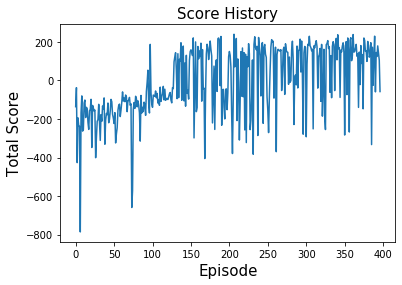

In [26]:
plt.plot(scores)
plt.title("Score History", fontsize = 15)
plt.xlabel("Episode", fontsize = 15)
plt.ylabel("Total Score", fontsize = 15)

DeepQNetwork(
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
  (loss): MSELoss()
)

In [28]:
#Extra credit: Use the polyak average as the weight update rule, as opposed to a variably lagged target. 

def polyak_update(polyak_factor, target_network, network):
    for target_param, param in zip(target_network.parameters(), network.parameters()):
        target_param.data.copy_(polyak_factor*param.data + target_param.data*(1.0 - polyak_factor))